In [1]:
import yaml
import numpy as np
from os import mkdir
from sys import argv
from scipy import special
from matplotlib import pylab as plt
from scipy.integrate import quad
from math import sqrt,cos, log10, pi
from scipy import optimize as sciopt
from scipy.interpolate import interp1d as interp
from functions_beta import integral2, Jfactor, nu
from multiprocessing import Pool
%matplotlib inline

In [2]:
# extract data from data files
def get_data(gal):
    # Read the parameter from the input file
    data = open('../data/params/params_%s.dat'%gal,'r').readlines()
    parameters = []
    for line in data:
        parameters.append(line.split(','))
    D  = float(parameters[1][0])       # distance to galaxy in kpc
    rh = float(parameters[2][0])       # half-light radius
    rt = float(parameters[3][0])       # tidal radius
    
    x,v,dv = np.loadtxt('../data/velocities/velocities_%s.dat'%gal,dtype=float,usecols=(0,1,2),unpack=True)
    return x,v,dv,D,rh,rt

In [3]:
stelprof = ['Plum','true_Plum','non_Plum']
DMprof = ['NFW_Cusp','NFW_Core']
stelmod = 2
DMmod = 1

In [4]:
# inverse hyperbolic cosecant (used for gamma* = 1 , non-Plum)
def inv_csch(x):
    return np.log(np.sqrt(1+x**-2.)+x**-1.)
# integrand of I(R) (used for gamma* = 0.1 , Plum)
def integrand_I(r,rh,R):
    return nu(r/rh)*r/np.sqrt(r**2-R**2)

# dwarf surface brightness profile
def I(R,rh):
    if stelmod==1: return 2*quad(integrand_I,R,+np.inf,args=(rh,R))[0] 
    else: 
        if stelmod==2: return 4./3.*rh/(1+(R/rh)**2)**2
        else: return rh**2*((2*rh**2+R**2)*inv_csch(R/rh)-rh*np.sqrt(rh**2+R**2))/(rh**2+R**2)**(3/2.)

In [5]:
names = {'booI':"Bootes I",'booII':"Bootes II",'car':"Carina",'com':"Coma Berenices",
'cvnI':"Canes Venatici I",'cvnII':"Canes Venatici II",'dra':"Draco",'for':"Fornax",
'her':"Hercules",'leoI':"Leo I",'leoIV':"Leo IV",'leoT':"Leo T",'scl':"Sculptor",
'seg1':"Segue 1",'sex':"Sextans",'sgr':"Sagittarius",'umaI':"Ursa Major I",
'umaII':"Ursa Major II",'umi':"Ursa Minor",'wil1':"Willman 1",}

In [319]:
dwarf = 'her'
dwarf_dir = '../output/OM/results/%s'%dwarf
#mkdir(dwarf_dir)
R,v,dv,D,rh,rt = get_data(dwarf)
u=v.mean()

In [333]:
theta=0.5

r0_i,r0_f,Nr0 = 1,3,100
ra_i,ra_f,Nra = 2,2,100

case = '%s_%i%i%i%i_%i'%(dwarf,r0_i,r0_f,ra_i,ra_f,theta*10)

In [334]:
r0_array = np.logspace(-r0_i,r0_f,Nr0)
ra_array = np.logspace(-ra_i,ra_f,Nra)
gamma_array = R/rh
alpha_array = rh/r0_array
delta_array = ra_array/rh
A_array = np.array([gamma_array[i]/I(Ri,rh) for i,Ri in enumerate(R)])
I_array = np.zeros(shape=(len(A_array),len(ra_array),len(r0_array)))

In [335]:
def array_builder(gamma_array, delta_array, alpha_array):
    for k,gamma in enumerate(gamma_array):
        for i,delta in enumerate(delta_array):
            for j,alpha in enumerate(alpha_array):
                yield (k, i, j), (gamma, delta, alpha)

def proxy(args):
    return args[0], A_array[args[0][0]]*integral2(*args[1])

In [ ]:
pool = Pool(processes=4)
results = pool.map(proxy, array_builder(gamma_array, delta_array, alpha_array))
pool.close()
pool.join()
for idx,value in results:
    I_array[idx] = value

In [ ]:
Jf = np.sqrt([Jfactor(D,np.inf,r0,1.,theta) for r0 in r0_array])

cst = 8.*np.pi*4.3e-6
# Likelihood definition (for free beta)
def logLike(J,i,j):
    I = cst*sqrt(J)*r0_array[j]**3*I_array[:,i,j]/Jf[j]
    S = dv**2.+I
    res = (np.log(S) + (v-u)**2./S).sum()
    return res/2.

In [ ]:
J_array = np.linspace(14,21,200)
J_new   = np.empty([0])
min_LikeJ  = np.empty([0])
min_ra_arr = np.empty([0])
min_r0_arr = np.empty([0])

for J in J_array:                                                # scan over an array of J values
    r0_new  = np.empty([0])
    ra_new  = np.empty([0])
    LikeJr0 = np.empty([0])
    for j,r0 in enumerate(r0_array):                             # for each J scan over an array of r0 values
        LikeJra = np.zeros_like(ra_array)
        for i in range(ra_array.size): LikeJra[i] = logLike(10**J,i,j)
        interp_Like_ra = interp(ra_array,LikeJra)                  # build the profile likelihood along ra
        
        eval_Like_ra = np.logspace(log10(ra_array.min()),log10(ra_array.max()),1e3)
        min_Like_ra  = interp_Like_ra(eval_Like_ra).min()
        min_ra       = eval_Like_ra[np.where(interp_Like_ra(eval_Like_ra)==min_Like_ra)[0][0]]
        
        if ra_array[1]<min_ra<ra_array[-2]:
            LikeJr0 = np.append(LikeJr0,min_Like_ra)
            ra_new  = np.append(ra_new,min_ra)
            r0_new  = np.append(r0_new,r0)
    
    if LikeJr0.size>3:
        interp_ra = interp(r0_new,ra_new)
        interp_r0 = interp(r0_new,LikeJr0)                  # build the profile likelihood along r0
        
        eval_Like_r0 = np.logspace(log10(r0_new.min()),log10(r0_new.max()),1e3)
        min_Like_r0  = interp_r0(eval_Like_r0).min()
        min_r0       = eval_Like_r0[np.where(interp_r0(eval_Like_r0)==min_Like_r0)[0][0]]
        
        if r0_new[1]<min_r0<r0_new[-2]:
            plt.semilogx(r0_new,interp_r0(r0_new),label='J=%.2f'%J)
            plt.plot(min_r0,min_Like_r0,'*',markersize=10,c='k')

            min_ra_arr = np.append(min_ra_arr,interp_ra(min_r0))
            min_r0_arr = np.append(min_r0_arr,min_r0)
            min_LikeJ  = np.append(min_LikeJ,min_Like_r0)
            J_new      = np.append(J_new,J)


#plt.ylim(50,52)
#plt.xlim(1e-2,1e0)
#plt.legend(bbox_to_anchor=(1.4,1))

In [ ]:
interp_Like_J  = interp(J_new,min_LikeJ)
interp_Like_ra = interp(J_new,min_ra_arr)
interp_Like_r0 = interp(J_new,min_r0_arr)

eval_Like_J = np.linspace(J_new.min(),J_new.max(),1e3)
min_Like_J  = interp_Like_J(eval_Like_J).min()
J_min       = eval_Like_J[np.where(interp_Like_J(eval_Like_J)==min_Like_J)[0][0]]

J_r0   = float(interp_Like_r0(J_min))
J_ra   = float(interp_Like_ra(J_min))
J_rho0 = 10**sciopt.minimize_scalar(lambda log10rho0 : abs(J_min-np.log10(Jfactor(D,np.inf,J_r0,1.,theta))-2*log10rho0)).x
print 'min J = ',round(J_min,2),' , ra = ',round(J_ra,3),' , r0 = ',round(J_r0,3)
plt.plot(J_new,interp_Like_J(J_new))
plt.plot(J_min,interp_Like_J(J_min),'b*')
#plt.ylim(39,40)

In [ ]:
J1sL = round(sciopt.minimize_scalar(lambda J : np.abs(interp_Like_J(J)-interp_Like_J(J_min)-0.5),
                                     method='Bounded',bounds=(J_new[0],J_min)).x-J_min,2)
J1sR = round(sciopt.minimize_scalar(lambda J : np.abs(interp_Like_J(J)-interp_Like_J(J_min)-0.5),
                                     method='Bounded',bounds=(J_min,J_new[-1])).x-J_min,2)

J2sL = round(sciopt.minimize_scalar(lambda J : np.abs(interp_Like_J(J)-interp_Like_J(J_min)-2.),
                                     method='Bounded',bounds=(J_new[0],J_min)).x-J_min,2)
J2sR = round(sciopt.minimize_scalar(lambda J : np.abs(interp_Like_J(J)-interp_Like_J(J_min)-2.),
                                     method='Bounded',bounds=(J_min,J_new[-1])).x-J_min,2)

J3sL = round(sciopt.minimize_scalar(lambda J : np.abs(interp_Like_J(J)-interp_Like_J(J_min)-4.),
                                     method='Bounded',bounds=(J_new[0],J_min)).x-J_min,2)
J3sR = round(sciopt.minimize_scalar(lambda J : np.abs(interp_Like_J(J)-interp_Like_J(J_min)-4.),
                                     method='Bounded',bounds=(J_min,J_new[-1])).x-J_min,2)

In [ ]:
print round(J_min,2),J1sL,J1sR,J2sL,J2sR,J3sL,J3sR

In [330]:
if J_min+J3sL-0.1>J_new[0]: J_i = J_min+J3sL-0.1
else: J_i = J_new[0]
if J_min+J3sR+0.1<J_new[-1]: J_f = J_min+J3sR+0.1
else: J_f = J_new[-1]
J_plt = np.linspace(J_i,J_f,100)

In [331]:
J1sL = J1sL if J_min+J1sL-0.01>=J_i else ''
J1sR = J1sR if J_min+J1sR+0.01<=J_f else ''
J2sL = J2sL if J_min+J2sL-0.01>=J_i else ''
J2sR = J2sR if J_min+J2sR+0.01<=J_i else ''
J3sL = J3sL if J_min+J3sL-0.01>=J_i else ''
J3sR = J3sR if J_min+J3sR+0.01<=J_i else ''

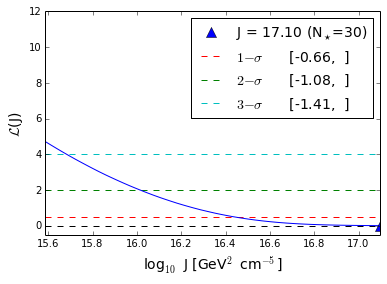

In [332]:
save = False
plt.plot(J_plt,interp_Like_J(J_plt)-interp_Like_J(J_min))
plt.plot(J_min,0,'b^',markersize=10,label='J = %.2f'%J_min+r' (N$_\star$=%i)'%R.size)
plt.hlines(0.,min(J_plt),max(J_plt),linestyles='dashed')
plt.hlines(.5,min(J_plt),max(J_plt),colors=('r'),linestyles='dashed',
           label=r'$1-\sigma$'+'\t'+'[%2s,%+2s]'%(str(J1sL),str(J1sR)))
plt.hlines(2,min(J_plt),max(J_plt),colors=('g'),linestyles='dashed',
           label=r'$2-\sigma$'+'\t'+'[%2s,%+2s]'%(str(J2sL),str(J2sR)))
plt.hlines(4,min(J_plt),max(J_plt),colors=('c'),linestyles='dashed',
           label=r'$3-\sigma$'+'\t'+'[%2s,%+2s]'%(str(J3sL),str(J3sR)))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.ylabel(r'$\mathcal{L}$(J)',fontsize=14)
plt.xlabel(r'log$_{10}$  J [GeV$^2$ cm$^{-5}$]',fontsize=14)
plt.ylim(-0.5,12)
plt.xlim(J_i,J_f)
if save:
    plt.savefig(dwarf_dir+'/%s_%s.png'%(DMprof[DMmod-1],stelprof[stelmod-1]),dpi=300,format='png')
    plt.suptitle('%s'%names[dwarf],fontsize=16)
    plt.savefig(dwarf_dir+'/%s_%s_title.png'%(DMprof[DMmod-1],stelprof[stelmod-1]),dpi=300,format='png')
    np.save(dwarf_dir+'/LikeJ_OM_%s'%case,np.vstack((J_plt,interp_Like_J(J_plt)-interp_Like_J(J_min))))
    yaml.dump({'Nstars':R.size,'Jmin':J_min,'r0':J_r0,'rho0':J_rho0,'ra':J_ra,'J1sL':J1sL,'J1sR':J1sR,
               
               'J2sL':J2sL,'J2sR':J2sR,'J3sL':J3sL,'J3sR':J3sR},open(dwarf_dir+'/results_OM_%s.yaml'%case,'w'))

In [318]:
print '%5s %10.2f'%('r0',J_r0)
print '%5s %10.2f'%('ra',J_ra)
print '%5s %10.2e'%('rho0',10**J_rho0)

   r0    6327.05
   ra       0.94
 rho0        inf


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:3: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()
